In [1]:
;cd "/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code/"

/home/bachir/Dropbox/AAA_Bachir/Learning_with_side_information/Code


In [2]:
]activate learning_ds

In [3]:
include("plotting_utilities.jl")
include("ode_helper.jl")
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using DataFrames

Loaded diff equations


In [4]:
m = 1.
g = 1. #9.81
ℓ = 1.
k = 1
α = g / ℓ

# vector field for the Elastic Pendulum
# q = x, p = m * ℓ^2 * ẋ
function hamiltonian(p, q)
    return m*g*ℓ * (1 - cos(q)) + p^2 / (2*m*ℓ^2)
end

function vf(ẋ, x)
    return [- m * g / ℓ * sin(x), ẋ]
end


rev_f(f) = (a,b) -> f(b, a)[end:-1:1]



x0 = 2*π/3
ẋ0 = 0.
T = 10
num_samples = 5
ẋ_t, x_t = solve_ode(vf, [ẋ0, x0]; verbose=true, tspan = (0., T), length=num_samples)

#ẋ_t = randn(num_samples) * π
#x_t = randn(num_samples) * π
ε = .1# * 0
noise_t = randn(num_samples) .* ε
size(x_t), size(noise_t)

Solving ODE from x0=[0.0, 2.0944]
size(sol) = (2, 19)
length = 5


((5,), (5,))

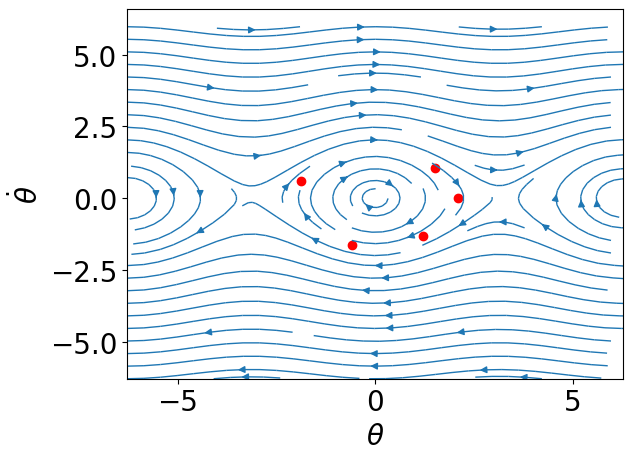

PyObject Text(44.472222222222214, 0.5, '$\\dot\\theta$')

In [180]:
pyplot(size = (400,400))
plot_vectorfield(rev_f(vf), (-2π, 2π, 100), (-2π, 2π, 100))
PyPlot.scatter(x_t, ẋ_t,  color=:red)
PyPlot.xlabel("\$\\theta\$")
PyPlot.ylabel("\$\\dot\\theta\$")

# Learn a polynomial lagrangian

<img src="polynomial_lagrangian.png">


In [207]:
@polyvar p q
# q = x, p = m * ℓ^2 * ẋ
max_deg = 8
monomials = [p^i * q^j for i=0:max_deg for j=0:max_deg if i+j < max_deg && i + j > 0]

model = SOSModel(with_optimizer(Mosek.Optimizer))
@variable model c[1:size(monomials, 1)]
@variable model γ

H = monomials' * c
                
#@constraint H(1, 1)
#@constraint model coefficients(H - H(p => p, q => -q)) .== 0
#@constraint model coefficients(H - H(p => -p, q => q)) .== 0
                
H

(c[35])p⁷ + (c[34])p⁶q + (c[32])p⁵q² + (c[29])p⁴q³ + (c[25])p³q⁴ + (c[20])p²q⁵ + (c[14])pq⁶ + (c[7])q⁷ + (c[33])p⁶ + (c[31])p⁵q + (c[28])p⁴q² + (c[24])p³q³ + (c[19])p²q⁴ + (c[13])pq⁵ + (c[6])q⁶ + (c[30])p⁵ + (c[27])p⁴q + (c[23])p³q² + (c[18])p²q³ + (c[12])pq⁴ + (c[5])q⁵ + (c[26])p⁴ + (c[22])p³q + (c[17])p²q² + (c[11])pq³ + (c[4])q⁴ + (c[21])p³ + (c[16])p²q + (c[10])pq² + (c[3])q³ + (c[15])p² + (c[9])pq + (c[2])q² + (c[8])p + (c[1])q

In [208]:
Hp = differentiate(H, p)
Hq = differentiate(H, q)

p_t = m * ℓ^2 * ẋ_t
q_t = x_t
q̇_t = ẋ_t
# ṗ = m ẍ = - m*g/ℓ * sin(x)
ṗ_t = - m*g/ℓ * sin.(x_t) .+ noise_t


error_term = [
    (q̇_t - Hp.(p_t, q_t))...,
    (ṗ_t + Hq.(p_t, q_t))...
     ]
@constraint model [γ, error_term...] in  SecondOrderCone()
0

0

In [209]:
size(noise_t), size(- m*g/ℓ * sin.(x_t))

((5,), (5,))

In [210]:
@objective model Min γ
# normalization constraint

optimize!(model)
@show value(γ) / size(error_term, 1)
# termination_status(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 11              
  Cones                  : 1               
  Scalar variables       : 47              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 10
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Optimizer terminated. Time: 0.00    

value(γ) / size(error_term,

-0.0

In [211]:
H_value = value.(H)
#learned_hamiltonian(pv, qv) = H_value(pv, qv)
@show value(γ)
H_value

value(γ) = -0.0


0.02674007316626002q⁷ - 0.07315060806471826q⁶ - 0.13148302310622634q⁵ + 0.4213382727424961q⁴ + 0.5p² - 0.19928374063771692q

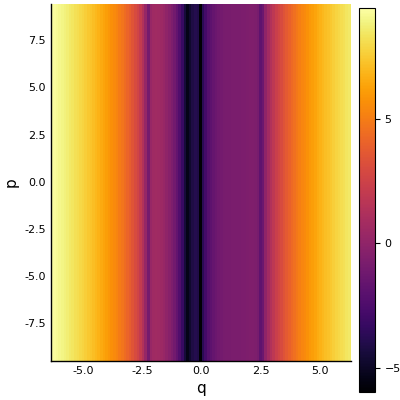

In [212]:
p_mesh = -3π:.1:3π
q_mesh = -2π:.11:2π
M = abs.(hamiltonian.(p_mesh, q_mesh') - H_value.(p_mesh, q_mesh'))
heatmap(q_mesh, p_mesh, log.(M))
xlabel!("q")
ylabel!("p")

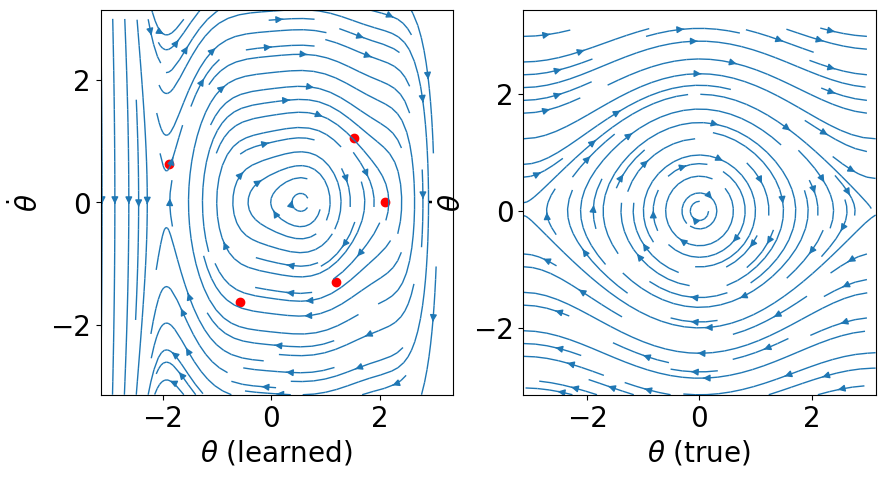

PyObject Text(467.1994949494949, 0.5, '$\\dot\\theta$')

In [213]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 20

learned_vf(θ̇,  θ) = [ -value(Hq)(m * ℓ^2 * θ̇, θ), value(Hp)(m * ℓ^2 * θ̇, θ) ]
figure(figsize=(10,5))

subplot(121)
learned_vf_plot = plot_vectorfield(rev_f(learned_vf), (-π, π, 100), (-π, π, 100))
PyPlot.scatter(x_t, ẋ_t, color=:red)
PyPlot.xlabel("\$\\theta\$ (learned)")
PyPlot.ylabel("\$\\dot\\theta\$")

subplot(122)
true_vf_plot = plot_vectorfield(rev_f(vf), (-π, π, 100), (-π, π, 100))
PyPlot.xlabel("\$\\theta\$ (true)")
PyPlot.ylabel("\$\\dot\\theta\$")




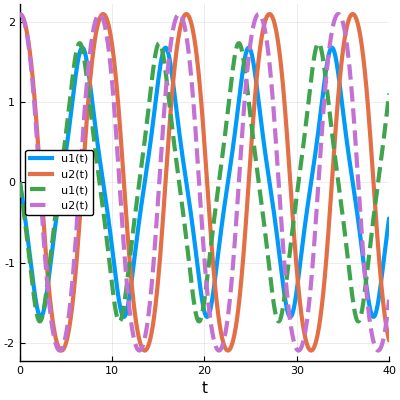

In [192]:
hamiltonian_vf(u, p, t) = learned_vf(u...)
true_vf(u, p, t) = vf(u...)

T_eval = 4*T
u₀ = [ẋ0, x0]

prob = ODEProblem(true_vf, u₀, (0., T_eval))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)


prob = ODEProblem(hamiltonian_vf, u₀, (0., T_eval))
hamiltonian_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
Plots.plot(hamiltonian_sol)
Plots.plot!(sol, ls=:dash)

#Plots.plot!(learned_sol, vars=(7, 8), color=:red)


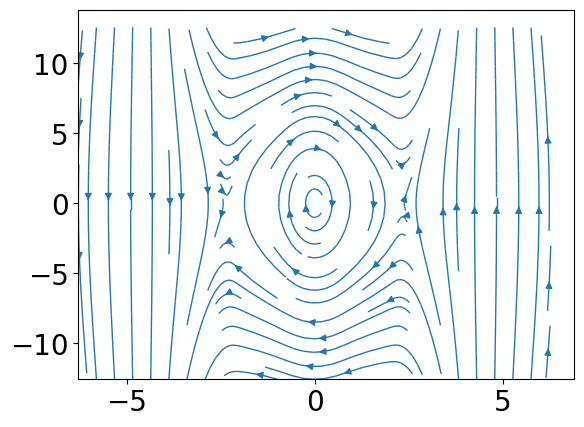

learned_hamiltonian_vf


In [16]:
using CSV
all_vfs = Dict(
                :learned_hamiltonian_vf => learned_vf, 
                #:true_vf => vf
        )
for k in all_vfs
    #rev_f(f)
    PyPlot.figure()
    name = string(k[1])
    println(name)
    f = rev_f(k[2])
    my_streamplot, segments, arrows = latex_vectorfield(f, (-2π, 2π, 10), (-4π, 4π, 10))
    CSV.write("segments_$name.csv", segments)
    CSV.write("arrows_$name.csv", arrows)
end

In [17]:
# export trajectories
hamiltonian_vf(u, p, t) = learned_vf(u...)
true_vf(u, p, t) = vf(u...)

T_eval = 2*T
u₀ = [0., π/3]

prob = ODEProblem(true_vf, u₀, (0., T_eval))
sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

prob = ODEProblem(hamiltonian_vf, u₀, (0., T_eval))
hamiltonian_sol = DifferentialEquations.solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)


num_samples = 50
dt = T_eval / num_samples

sol_dict = Dict(:true_vf=>sol, :learned_hamiltonian_vf=>hamiltonian_vf)
for sol_entry in sol_dict
    name = string(sol_entry[1])
    print(name)
    sol = sol_entry[2]

    u = []
    for i=1:num_samples            
        push!(u, [i*dt, sol(dt*i)...])
    end
    u = hcat(u...)'
    print(size(u))
    u  = convert(DataFrame, u)
    names!(u, [:t, :theta_dot, :theta])
    CSV.write("trajectory_$name.csv", u)
end

learned_hamiltonian_vf

MethodError: MethodError: no method matching hamiltonian_vf(::Float64)
Closest candidates are:
  hamiltonian_vf(::Any, !Matched::Any, !Matched::Any) at In[17]:2

In [18]:
?names!

search: names! GeometricBrownianMotionProcess! names fieldnames



Set column names

```julia
names!(df::AbstractDataFrame, vals)
```

**Arguments**

  * `df` : the AbstractDataFrame
  * `vals` : column names, normally a Vector{Symbol} the same length as the number of columns in `df`
  * `makeunique` : if `false` (the default), an error will be raised if duplicate names are found; if `true`, duplicate names will be suffixed with `_i` (`i` starting at 1 for the first duplicate).

**Result**

  * `::AbstractDataFrame` : the updated result

**Examples**

```julia
df = DataFrame(i = 1:10, x = rand(10), y = rand(["a", "b", "c"], 10))
names!(df, [:a, :b, :c])
names!(df, [:a, :b, :a])  # throws ArgumentError
names!(df, [:a, :b, :a], makeunique=true)  # renames second :a to :a_1
```
